In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords') # Get the stop words list
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
from collections import defaultdict
import pickle
from sklearn.metrics import accuracy_score, classification_report, f1_score
from google.colab import files
import warnings
import time
from nltk.corpus import stopwords
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### This code was used locally (offline) to pool train and test text files into train and test csv files. Adjust if you want to run on another system

In [ ]:

drc = 'C:\\Users\\mahdi\\OneDrive - McGill University\\Work and studies\\Courses\\Project 3\\aclImdb_v1\\aclImdb\\train\\'
fldr_nam  = ['pos', 'neg']
  
def txt2table(drc=drc, fldr_nam=fldr_nam):
    
    '''
    Pool all text comments and their semantics into pandas dataframes
    '''
    
    semantic = []
    rev = []

    for fldr in fldr_nam:
        tmp_dir = drc + fldr 
        os.chdir(tmp_dir) #change directory to the folder
        for file in os.listdir(tmp_dir):
            if file.endswith(".txt"):
                try:
                    with open(file, 'r', encoding='utf-8') as h:
                        tmp_txt = h.read().replace('\n', '') # Remove paragraph markers
                        semantic.append(fldr)
                        rev.append(tmp_txt)
                except:
                    print(file)
                    raise Exception('Error reading file')
    
    dat = pd.DataFrame(list(zip(rev, semantic)), columns = ['comment', 'semantic'])
    return dat        

train_dat = txt2table()
train_dat.to_csv('C:\\Users\\mahdi\\OneDrive - McGill University\\Work and studies\\Courses\\Project 3\\train.csv')

tst_drc = 'C:\\Users\\mahdi\\OneDrive - McGill University\\Work and studies\\Courses\\Project 3\\aclImdb_v1\\aclImdb\\test\\'
test_dat = txt2table(tst_drc)
test_dat.to_csv('C:\\Users\\mahdi\\OneDrive - McGill University\\Work and studies\\Courses\\Project 3\\test.csv')


In [ ]:
# Mount google drive containing train and test csv files
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_pth = '/content/drive/MyDrive/train.csv'
dat = pd.read_csv(train_pth)
test_pth = '/content/drive/MyDrive/test.csv' 
tst_dat = pd.read_csv(train_pth)

### Auxilary functions to help with data cleaning, lemmatization, and other tasks

In [ ]:
def clean(text):
    '''
    Function to remove html markers, non alphanumeric characters and additional white spaces
    '''
    no_html = BeautifulSoup(text).get_text()
    clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)    
    clean = re.sub("(\s+)", " ", clean)
    clean = clean.lower()
    return clean


def lemmatize(text): # The process of grouping together different inflected forms of the same word
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

def laplace_smoothing(n_label_items, vocab, word_counts, word, text_label): # Avoid erors on the words not seen in train set
    a = word_counts[text_label][word] + 1
    b = n_label_items[text_label] + len(vocab)
    return np.log(a/b)

def group_by_label(x, y, labels):
    data = {}
    for l in labels:
        data[l] = x[np.where(y == l)]
    return data



### Naive Bayesian class

In [ ]:
class NB:
    
    def __init__(self, dat, tst_dat):
        
        self.dat = dat
        self.tst_dat = tst_dat
        
    def clean_encode(self):
        '''
        Remove stop words, lemmatize, and encode labels. Might take some time to run
        '''
        
        
        stop_words = set(stopwords.words('english')) # get a set of stop words 
        # Clean htmls etc and remove stop words
        self.dat['comment'] = self.dat['comment'].apply(lambda cw : clean(cw)) 
        self.dat['comment'] = self.dat['comment'].apply(lambda x: ' '.join([wrd for wrd in x.split() if wrd not in (stop_words)]))
        self.tst_dat['comment'] = self.tst_dat['comment'].apply(lambda cw : clean(cw)) 
        self.tst_dat['comment'] = self.tst_dat['comment'].apply(lambda x: ' '.join([wrd for wrd in x.split() if wrd not in (stop_words)]))
    
        #Lemmatize
        self.dat['comment'] = self.dat.comment.apply(lemmatize)
        self.tst_dat['comment'] = self.tst_dat.comment.apply(lemmatize)
        
        self.comment_train = self.dat['comment'].values
        output_train = self.dat['semantic'].values
        encoder = LabelEncoder()
        self.labels_train = encoder.fit_transform(output_train)

        # 1: Positive 0: negative

        self.comment_test = self.tst_dat['comment'].values
        output_train = self.tst_dat['semantic'].values
        encoder = LabelEncoder()
        self.labels_test = encoder.fit_transform(output_train)
        
    def toknz(self, ngram_range=(1,1), max_features=None, prnt=True):
        '''
        vectorize training set
        '''
        cnt = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
        tknz_x = cnt.fit_transform(self.comment_train)
        vocab = cnt.get_feature_names_out()
        tknz_x = tknz_x.toarray()
        word_counts = {}
        
        print('Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape')
        for l in np.unique(self.labels_train):
            word_counts[l] = defaultdict(lambda: 0)
        for i in range(tknz_x.shape[0]):
            if i%500==0 and prnt:
                print(f'{i} from {tknz_x.shape[0]} total instances')
            l = self.labels_train[i]
            for j in range(len(vocab)):
                word_counts[l][vocab[j]] += tknz_x[i][j]                                             
                                               
                                               
        self.word_counts =  word_counts
        self.vocab = vocab                                      

    def fit(self, x, y, labels=[0,1]):
        '''
        Fit the model via calculating log priors and likelihoods
        '''
        prior_logs = {}
        label_items = {}
        
        n = len(x)
        grouped_data = group_by_label(x, y, labels)
        for l, data in grouped_data.items():
            label_items[l] = len(data)
            prior_logs[l] = np.log(label_items[l] / n)
        self.label_items = label_items
        self.prior_logs = prior_logs
 
    def predict(self, x, labels=[0,1]):
        w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
        y_pred = []
        print('Attention. Predicting might take some time to complete on the test set')
        for text in x:
            label_scores = {l: self.prior_logs[l] for l in labels}
            words = set(w_tokenizer.tokenize(text))
            for wrd in words:
                if wrd not in self.vocab:
                    continue
                for l in labels:
                    log_w_given_l = laplace_smoothing(self.label_items, self.vocab,
                                                      self.word_counts, wrd, l)
                    label_scores[l] += log_w_given_l # Use log of probabilities for prediction as we dont directly need posterior probabilities
            
            y_pred.append(max(label_scores, key=label_scores.get))
        self.y_pred = y_pred 
        return y_pred 

    def evaluate_acc(self, y_pred, y, clas_rprt = True):
        
        acr = accuracy_score(y, y_pred)*100
        
        print(f'Accuracy of prediction on test set : {acr}')
         
        if clas_rprt:
            print(classification_report(y, y_pred))



In [ ]:
nb = NB(dat, tst_dat)

nb.clean_encode()
nb.toknz( ngram_range=(1,1), max_features=4000)
x = nb.comment_train
y = nb.labels_train

nb.fit(x, y)




In [ ]:
y_pred = nb.predict(nb.comment_test)
y_pred = np.array(y_pred)
y_test = nb.labels_test

nb.evaluate_acc(y_pred, y_test)

### Additional experimentation. Observe the effect of maximum number of features and different forms of ngrams from CountVectorizer token counter.

In [ ]:
mx_feature_pool = [4000, 8000, 12000, None]
acr = []
f1 = []
tim = []
for mx in mx_feature_pool:
    nb = NB(dat, tst_dat)
    tic = time.time()
    nb.clean_encode()
    nb.toknz(ngram_range=(1,1), max_features=mx, prnt=False)
    x = nb.comment_train
    y = nb.labels_train

    nb.fit(x, y)

    y_pred = nb.predict(nb.comment_test)
    toc = time.time()
    y_pred = np.array(y_pred)
    y_test = nb.labels_test

    acr.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))

    tim.append(toc-tic)

Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set
Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set
Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set
Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set


In [ ]:
max_dic = {'acr': acr, 'f1': f1, 'time': tim}
import pickle
with open('max_dic.pickle', 'wb') as h:
    pickle.dump(max_dic, h)

In [ ]:
import matplotlib.pyplot as plt

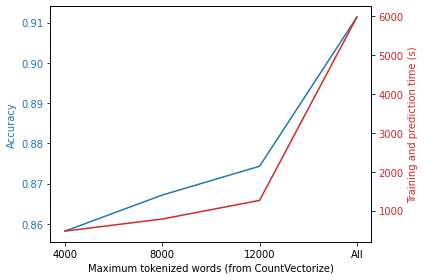

In [ ]:
xlabls = [4000, 8000, 12000, 'All']
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Maximum tokenized words (from CountVectorize)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(acr, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(mx_feature_pool)))
ax1.set_xticklabels(xlabls)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Training and prediction time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(tim, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('max_tokn_acr.jpg', dpi=150)

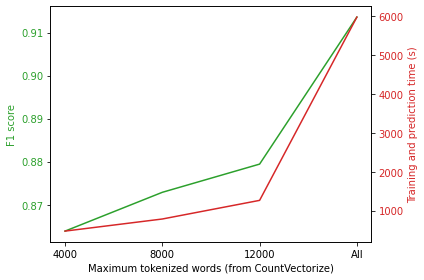

In [ ]:
xlabls = [4000, 8000, 12000, 'All']
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Maximum tokenized words (from CountVectorize)')
ax1.set_ylabel('F1 score', color=color)
ax1.plot(f1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(mx_feature_pool)))
ax1.set_xticklabels(xlabls)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Training and prediction time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(tim, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('max_tokn_f1.jpg', dpi=150)

In [ ]:
#max features is set to 4000 for comparision
ngram_pool = [(1,1), (1,2), (1,3), (1,4)]
acr = []
f1 = []
tim = []
for ngrm in ngram_pool:
    nb = NB(dat, tst_dat)
    tic = time.time()
    nb.clean_encode()
    nb.toknz(ngram_range=ngrm, max_features=4000, prnt=False)
    x = nb.comment_train
    y = nb.labels_train

    nb.fit(x, y)

    y_pred = nb.predict(nb.comment_test)
    toc = time.time()
    y_pred = np.array(y_pred)
    y_test = nb.labels_test

    acr.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))

    tim.append(toc-tic)

Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set
Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set
Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set
Initiating tokenization. the process might take some time depending on the maximum number of features and ngram shape
Attention. Predicting might take some time to complete on the test set


In [ ]:
ngrm_dic = {'acr': acr, 'f1': f1, 'time': tim}
import pickle
with open('ngrm_dic.pickle', 'wb') as h:
    pickle.dump(ngrm_dic, h)

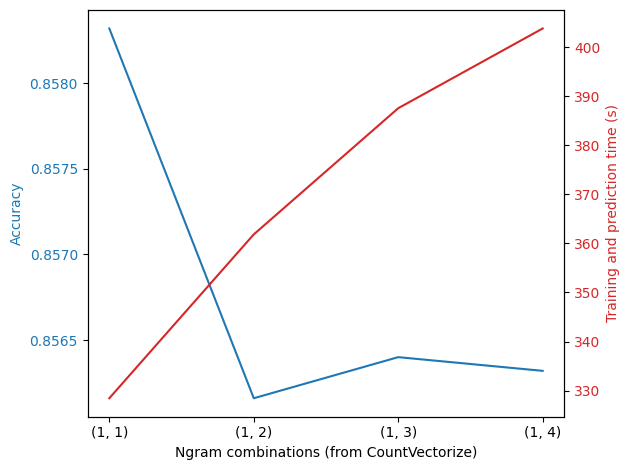

In [ ]:
xlabls = [(1,1), (1,2), (1,3), (1,4)]
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Ngram combinations (from CountVectorize)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(acr, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(xlabls)))
ax1.set_xticklabels(xlabls)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Training and prediction time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(tim, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('ngrm_tokn_acr.jpg', dpi=150)

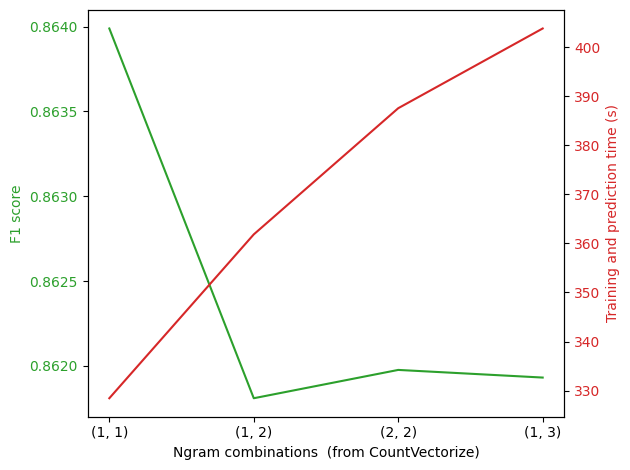

In [ ]:
xlabls = [(1,1), (1,2), (2,2), (1,3)]
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Ngram combinations  (from CountVectorize)')
ax1.set_ylabel('F1 score', color=color)
ax1.plot(f1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(xlabls)))
ax1.set_xticklabels(xlabls)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Training and prediction time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(tim, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('ngrm_tokn_f1.jpg', dpi=150)